# 제주도 호텔 리뷰에 대한 감정분석 수행하기
- **선택 #2: 10주차 이후 배운 텍스트마이닝 예비 프로젝트 중 하나를 발전/향상 시켰습니다.**


- Tripadvisor의 제주도 호텔 리뷰 데이터를 크롤링하여 딥러닝으로 감성 분류를 진행하였습니다. 국내 대표 여행지인 제주도의 호텔에 대하여 텍스트 마이닝을 통하여 알아보았습니다. 제주도 호텔들의 리뷰를 분석해보면서, 호텔 고객들의 전체적인 반응이 어떠한지 살펴보고, 개선점 등을 알아보았습니다. 



- 1) 데이터의 종류: Tripadvisor 호텔 리뷰 스크래핑한 데이터(약 4000개. 컴퓨터 성능의 한계로 4000개 스크래핑 시 약 40분이 걸렸습니다.)
- 2) 웹스크래핑 포함: Tripadvisor 웹사이트에서 직접 스크래핑하였습니다.
- 3) 텍스트마이닝 관련 코드 포함: 레이블링, 전처리, LSTM과 GRU 모델 구축하여 성능을 비교해보았습니다.


- Tripadvisor 사이트를 스크래핑할 때, 기존에 다루었던 다음과 네이버 뉴스사이트와는 많은 차이가 있었습니다. 그래서 어떠한 차이가 있는지 주석으로 설명을 달아놓았습니다.
- 감정분석에 관하여 '네이버 영화 리뷰 감성 분류하기 위키독스 글'을 참고하여 진행하였습니다. (https://wikidocs/net/44249)

In [1]:
!pip install konlpy

In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf/

'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [195]:
# 패키지 불러오기
import numpy as np                    
import pandas as pd                   
import matplotlib.pyplot as plt       

from collections import Counter

from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings('ignore')

# Tripadvisor에서 호텔 리뷰 스크래핑하기
* 제주도 유명 호텔 중, 후기가 많은 호텔을 추려서 스크래핑을 수행했습니다.
* 제주 신라호텔, 롯데 호텔 제주, 베스트 웨스턴 제주 호텔, 메종 글래드 호텔, 랜딩관 제주신화월드 호텔 앤 리조트의 후기를 스크래핑하여 데이터프레임으로 만들었습니다.

In [21]:
'''
5개의 호텔의 리뷰 페이지를 더 효과적으로 크롤링하기 위하여 url에 들어가는 파라미터들을 정리하여 사용합니다.
물음표 뒤에 나타난 것은 아니므로 쿼리 스트링이라고 할 수는 없지만, 그래도 코드를 효율적으로 사용하기 위해 이와 같이 정리해보았습니다.
'''
hotel_key = ['d301723', 'd306055', 'd455471', 'd8093030', 'd12788881']

hotel_full_list = ['The_Shilla_Jeju-Seogwipo_Jeju_Island', 'LOTTE_HOTEL_JEJU-Seogwipo_Jeju_Island', 
                   'Maison_Glad_Jeju-Jeju_Jeju_Island',  'Best_Western_Jeju_Hotel-Jeju_Jeju_Island', 
                   'Landing_Jeju_Shinhwa_World_Hotels_Resorts-Seogwipo_Jeju_Island']

In [6]:
rating_list = []
title_list = []
text_list = []

    
# 호텔 리뷰 데이터 스크래핑을 위한 함수 정의
def web_scraping(end, hotel_input, start=1):

  while 1: 
    if start > end :   # 스타트 페이지가 마지막 페이지보다 크면 while 문을 빠져 나감 
      break

    # TripAdvisor url의 특성을 고려하여 추가된 수식
    a = (start-1) * 5
    '''
    putin 변수는 TripAdvisor의 url이 첫 페이지에서는 아무것도 없지만, 
    다음 페이지로 넘어갈 때, url 중간에 'or5-'가 추가되고, 
    그 다음 페이지는 'or10-', 'or15-' 이런식으로 값이 늘어나는 굉장히 특이한 url 모습을 보이고 있어, 
    이를 반영하기 위해서 만든 변수입니다.
    '''
    putin = 'or'+str(a)+'-'
    if a == 0: 
      putin = ''

    # hotel_key, hotel_full_list 값을 사용하여 url을 돌려 재사용성을 높임
    if hotel_input == '신라 호텔': 
        j = 1
    elif hotel_input == '롯데 호텔':
        j = 2
    elif hotel_input == '신화 호텔':
        j = 3
    elif hotel_input == '베스트 웨스틴 제주':
        j = 4
    else:
        j = 5
    
    url = 'https://www.tripadvisor.co.kr/Hotel_Review-g297892-{0}-Reviews-{1}{2}.html'.format(hotel_key[j-1], putin, hotel_full_list[j-1])
    req = requests.get(url)   # 해당 페이지를 가져옴        
    page = BeautifulSoup(req.text, 'html.parser')

    # 태그가 'div'이고 div의 class가 아래와 같은 것들을 BeautifulSoup으로 모두 리스트 형태로 출력함
    rating = page.find_all('div', 'nf9vGX55') # 리뷰 평점(0-50)
    title = page.find_all('div', "glasR4aX") # 리뷰 제목
    text = page.find_all('div', class_='cPQsENeY') #리뷰 내용

    #평점 다듬기
    '''
    평점이 일반적인 html에서 텍스트 추출 시 바로 얻을 수 있는 것이 아니라 아래와 같이 span 태그의 클래스로 문자들과 묶여있는 형태입니다.
    ex. <div class="nf9vGX55" data-test-target="review-rating"><span class="ui_bubble_rating bubble_30"></span></div>
    그래서 위의 데이터 포맷에서 span 태그를 추출한 후, 정규표현식으로 평점에 해당하는 숫자 부분만 출력하였습니다.
    '''
    import re
    for i in rating:
      i = i.find('span')
      i = str(i)
      result = re.findall(r'\d+', i) # 정규표현식 사용하여 숫자 추출.
      rating_list.extend(result)

    #리뷰 제목 다듬기
    for i in title:
      i = i.get_text()
      title_list.append(i)

    #리뷰 본문 추출하기
    '''
    리뷰 본문의 경우, 유저의 후기만 출력되는 것이 아니라 호텔에서 단 답글까지 출력이 되어 이를 제외하고자 %를 사용하였습니다.
    '''
    for i in range(len(text)):
      if i % 2 == 1:
        result = text[i].get_text()
        text_list.append(result)

    start = start+1

In [8]:
# 크롤링 시간이 약 1시간 정도 걸렸습니다.

# 신라 호텔
web_scraping(end=200, hotel_input='신라 호텔')

# 롯데 호텔
web_scraping(end=200, hotel_input='롯데 호텔')

# 신화 호텔
web_scraping(end=200, hotel_input='신화 호텔')

# 메종 글래드 제주
web_scraping(end=200, hotel_input='메종 글래드 제주')

# 베스트 웨스틴 제주 호텔
web_scraping(end=200, hotel_input='베스트 웨스틴 제주')

In [130]:
# 스크래핑한 데이터를 데이터프레임으로 만든다
import pandas as pd
df = pd.DataFrame({'title': title_list[:3788], 'text': text_list, 'rating': rating_list[:3788]})
df

,title,text,rating
0,수영장에서의 기분좋은 하루!,"롯데2박신라2박그랜드조선2박 여행중인데, 역시 신라가 최고네요. 어제 수영장 책임자...",50
1,언제나 친절 한 곳,제주도로 이사와서 코로나 이전에 일주일에 한두번씩 거의 2년 정도 가족들과 주로 점...,50
2,제주 신라호텔 추천!,도착하자마자 호텔 직원이 일대일 짐케어 해주시고 객실까지 안내해주었어요 벨직원 뿐만...,50
3,최고,오래된 호텔이지만 어느 신설호텔보다도 더 깔끔하고 유지보수가 매우 잘 되어있는 호텔...,50
4,오래됐지만 여전히 고급스럽고 깔끔한 고품격 호텔,중문에 위치하여 접근성이 좋습니다. 주변에 맛집과 관광지가 많아 이동하기도 편합니다...,50
...,...,...,...
3783,메종 글래드 제주 만족!,제주도 메종글래드에스 2박했어요 직원분들도 친절하시고 방도 깔끔해서 좋았어요 다음에...,50
3784,생각보다 너무 좋아요,"공항에서 가깝고 넓은 게 맘에 들어 예약했는데, 접근성 뿐만 아니라 편의성도 최고였...",40
3785,좋아요,엊그제 지인들과 2박을 햇는데 잠금장치가 고장나 아침 체크아웃시간에 난리가 낫엇습니...,50
3786,편안하게 머물기에 최고의 숙소!,"들어올 때부터 나갈 때까지 완벽했던 메종 글래드 제주!! 일반 객실로 예약했지만, ...",50


In [131]:
# 추후에 훈련 데이터와 테스트 데이터를 분리할 최대한 unbiased하게 나누어지게 하기 위하여 데이터를 섞는다
df=df.sample(frac=1).reset_index(drop=True)
df[:20]

,title,text,rating
0,제주 신라호텔 추천!,도착하자마자 호텔 직원이 일대일 짐케어 해주시고 객실까지 안내해주었어요 벨직원 뿐만...,50
1,좋아요,엊그제 지인들과 2박을 햇는데 잠금장치가 고장나 아침 체크아웃시간에 난리가 낫엇습니...,50
2,바람부는날에 삐하는 계속되는 창문소리에 새벽에 일어나야 했습니다,"룸에 들어오자마자 카드,초콜릿 선물 감사요 궁금한점 친절히 설명해주시고 룸컨디션 너...",20
3,베스트웨스턴 제주호텔^^♡,Wander49368330548님 먼저 저희 호텔을 방문해 주시고 호텔 전반적...,50
4,시설은 좋았으나 서비스는..좀 아쉬웠습니다.,작녁 여름에 여행갔을 때 체크인서비스 등은 친절히 잘해 주셨어요. 근데 객실에 갔을...,20
5,[가족여행 호텔],방크기. 로비. 가격. 서비스 모두 시원시원한곳. 비데가 없어서 불편하지만 모두 만...,40
6,베스트웨스턴 최고네요,Straw7님 먼저 저희 호텔을 방문해 주시고 호텔 전반적인 부분에 대해서 만...,50
7,제주 시의 세련된 호텔,가족이 즐기기 좋은 리조트 시설과 서비스 모두 만족하고 아이들 키즈 액티비티 프로그...,40
8,제주 메종글래드 호텔 너무 좋아요^^,제주도 메종글래드에스 2박했어요 직원분들도 친절하시고 방도 깔끔해서 좋았어요 다음에...,50
9,햇빛이 안드는 반지하 같은 방,"역시 제주 신화 월드는 최고라는 말이 나올 정도로 쾌적하고, 즐거웠습니다. 주차도 ...",10


In [132]:
# 데이터프레임을 csv로 변환하여 저장함
df.to_csv('C:\\Users\\user\\Documents\\jeju_hotel_review.csv')

In [430]:
# 저장한 csv 파일 불러와서 사용함
import pandas as pd

df = pd.read_csv('C:\\Users\\user\\Documents\\jeju_hotel_review.csv', encoding='UTF-8')
df.head()

,Unnamed: 0,title,text,rating
0,0,제주 신라호텔 추천!,도착하자마자 호텔 직원이 일대일 짐케어 해주시고 객실까지 안내해주었어요 벨직원 뿐만...,50
1,1,좋아요,엊그제 지인들과 2박을 햇는데 잠금장치가 고장나 아침 체크아웃시간에 난리가 낫엇습니...,50
2,2,바람부는날에 삐하는 계속되는 창문소리에 새벽에 일어나야 했습니다,"룸에 들어오자마자 카드,초콜릿 선물 감사요 궁금한점 친절히 설명해주시고 룸컨디션 너...",20
3,3,베스트웨스턴 제주호텔^^♡,Wander49368330548님 먼저 저희 호텔을 방문해 주시고 호텔 전반적...,50
4,4,시설은 좋았으나 서비스는..좀 아쉬웠습니다.,작녁 여름에 여행갔을 때 체크인서비스 등은 친절히 잘해 주셨어요. 근데 객실에 갔을...,20


In [431]:
# rating 칼럼값을 숫자로 변환
df['rating'] = pd.to_numeric(df['rating'])
df.dtypes

Unnamed: 0     int64
title         object
text          object
rating         int64
dtype: object

# 레이블링

TripAdvisor의 평점이 굉장히 후하다는 것을 감안하여, 평점이 40점 초과일 때 긍정, 40점 이하일 때 부정으로 판단하였습니다.
감정분석을 위하여 기존의 평점값을 대체하여 긍정일 경우 1, 부정일 경우 0으로 레이블링하였습니다.

In [432]:
# 레이블링 진행
for i in range(len(df)):
  if df['rating'][i] == 50 :
    df['rating'][i] = 1
  elif df['rating'][i] <= 30:
    df['rating'][i] = 0
  else: 
    df['rating'][i] = ''

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexi

In [433]:
df

,Unnamed: 0,title,text,rating
0,0,제주 신라호텔 추천!,도착하자마자 호텔 직원이 일대일 짐케어 해주시고 객실까지 안내해주었어요 벨직원 뿐만...,1
1,1,좋아요,엊그제 지인들과 2박을 햇는데 잠금장치가 고장나 아침 체크아웃시간에 난리가 낫엇습니...,1
2,2,바람부는날에 삐하는 계속되는 창문소리에 새벽에 일어나야 했습니다,"룸에 들어오자마자 카드,초콜릿 선물 감사요 궁금한점 친절히 설명해주시고 룸컨디션 너...",0
3,3,베스트웨스턴 제주호텔^^♡,Wander49368330548님 먼저 저희 호텔을 방문해 주시고 호텔 전반적...,1
4,4,시설은 좋았으나 서비스는..좀 아쉬웠습니다.,작녁 여름에 여행갔을 때 체크인서비스 등은 친절히 잘해 주셨어요. 근데 객실에 갔을...,0
...,...,...,...,...
3783,3783,확실히 한국에서 최고의 호텔,"롯데2박신라2박그랜드조선2박 여행중인데, 역시 신라가 최고네요. 어제 수영장 책임자...",1
3784,3784,아이가 좋아하는 키즈룸,자동차침대까지 있어서 초등학생 아들이랑 유치원 딸까지 넘 좋아했어요 객실도 깨끗하고...,
3785,3785,최고의 리조트,롯데호텔 저녁에 야경도 예쁘고 째즈 공연도 정말 좋았습니다. 다만 가족이 많아서 수...,1
3786,3786,베스트웨스턴제주호텔짱짱맨,Euniuuu님 먼저 저희 호텔을 방문해 주시고 호텔 전반적인 부분에 대해서 ...,1


In [434]:
# 다시 레이블을 문자로 변환
df['rating'] = df['rating'].astype(str)

In [435]:
# 레이블된 데이터프레임을 csv로 변환하여 저장함
df.to_csv('C:\\Users\\user\\Documents\\jeju_hotel_review_labled.csv')

In [437]:
# 다시 레이블을 문자로 변환
df['rating'] = df['rating'].astype(str)

<AxesSubplot:>

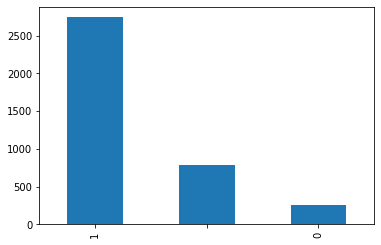

In [438]:
# matplotlib로 라벨 별로 데이터가 몇 개씩 존재하는지 알아보기
df['rating'].value_counts().plot(kind = 'bar')

# 데이터의 분포가 긍정으로 더 치우쳐져 있음을 알 수 있습니다.

In [439]:
len(df)

3788

In [440]:
# 긍부정 개수 구하기
print(df.groupby('rating').size().reset_index(name = 'count'))

  rating  count
0           791
1      0    255
2      1   2742


In [441]:
idx = df[df['rating']==''].index
df = df.drop(idx)
len(df)

2997

# 데이터의 전처리

In [442]:
# 한글과 공백 제외하고 모두 제거
df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['title'] = df['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df.head()

,Unnamed: 0,title,text,rating
0,0,제주 신라호텔 추천,도착하자마자 호텔 직원이 일대일 짐케어 해주시고 객실까지 안내해주었어요 벨직원 뿐만...,1
1,1,좋아요,엊그제 지인들과 박을 햇는데 잠금장치가 고장나 아침 체크아웃시간에 난리가 낫엇습니다...,1
2,2,바람부는날에 삐하는 계속되는 창문소리에 새벽에 일어나야 했습니다,룸에 들어오자마자 카드초콜릿 선물 감사요 궁금한점 친절히 설명해주시고 룸컨디션 너무...,0
3,3,베스트웨스턴 제주호텔,님 먼저 저희 호텔을 방문해 주시고 호텔 전반적인 부분에 대해서 만족하셨다는 ...,1
4,4,시설은 좋았으나 서비스는좀 아쉬웠습니다,작녁 여름에 여행갔을 때 체크인서비스 등은 친절히 잘해 주셨어요 근데 객실에 갔을 ...,0


In [443]:
#한글과 공백 제외하고 모두 제거한 뒤, Null값이 있는지 다시 한 번 확인하기
print(df.isnull().values.any())

False


In [444]:
# 훈련 데이터와 테스트 데이터 분리하기
# 훈련 데이터가 엄청 많은 것은 아니기 때문에, 50:50으로 훈련시킬 수는 없어 
# train_data에 더 많은 비율을 할당했다


train_data = df[:2000]
test_data = df[2000:]

In [445]:
test_data

,Unnamed: 0,title,text,rating
2527,2527,우리나라 최고의 호텔,호텔의 놀라운 시설 호텔 내의 카지노 아름다운 정원 온수 수영장으로 공항까지 셔틀 ...,1
2528,2528,여행 마무리 잘하고 갑니다,깔끔하고 넓은 호텔시설에 놀랐고 호텔 내 온도조절도 시원해 쾌적합니다 와이파이 문제...,1
2529,2529,깔끔하고 좋아요,님 먼저 저희 호텔을 방문해 주시고 호텔 전반적인 부분에 대해서 만족하셨다는 ...,1
2530,2530,잘 머물다 갑니다,고객 그이상의 대우를 받은듯 합니다 힘들었던 모든 부분 위로 받고 옵니다 조만간 또...,1
2531,2531,즐거운 제주 여행 롯데에서,휴식을 취하기 위해서 찾았던 호텔 직원들도 친절하고 조용하고 힐링할 수 있는 시간이...,1
...,...,...,...,...
3781,3781,편안하게 머물기에 최고의 숙소,들어올 때부터 나갈 때까지 완벽했던 메종 글래드 제주 일반 객실로 예약했지만 디럭스...,1
3783,3783,확실히 한국에서 최고의 호텔,롯데박신라박그랜드조선박 여행중인데 역시 신라가 최고네요 어제 수영장 책임자분이라는 ...,1
3785,3785,최고의 리조트,롯데호텔 저녁에 야경도 예쁘고 째즈 공연도 정말 좋았습니다 다만 가족이 많아서 수영...,1
3786,3786,베스트웨스턴제주호텔짱짱맨,님 먼저 저희 호텔을 방문해 주시고 호텔 전반적인 부분에 대해서 만족하셨다는 ...,1


# 토큰화

In [448]:
# 불용어 제거
# 불용어 사전을 참고하였습니다. (출처: https://bab2min.tistory.com/544)

stopwords = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', 
             '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', 
             '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', 
             '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', 
             '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', 
             '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', 
             '안', '어떤', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', 
             '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', 
             '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '자','에','와', '하다',
             '의','가','은','는','걍','과','도','를','으로']

In [449]:
# Okt 형태소 분석기 사용
from konlpy.tag import Okt

okt = Okt()

In [450]:
# 데이터에 형태소 분석기 사용(토큰화, 불용어 제거)

# 리뷰 내용(text)에 대해서 진행한다
X_train = []
for sentence in train_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [451]:
X_train[:10]

[['도착',
  '자마자',
  '호텔',
  '직원',
  '일대일',
  '짐',
  '케어',
  '해주시',
  '고',
  '객실',
  '까지',
  '안내',
  '해주다',
  '벨',
  '직원',
  '뿐',
  '만',
  '아니다',
  '모든',
  '직원',
  '다',
  '친절하다',
  '기분',
  '좋다',
  '투숙',
  '하고',
  '가다',
  '친구',
  '랑',
  '함께',
  '뚜벅',
  '여행',
  '이어서',
  '이동',
  '쉬다',
  '않다',
  '호텔',
  '시설',
  '이며',
  '서비스',
  '모두',
  '훌륭하다',
  '다음',
  '제',
  '여행',
  '에도',
  '신라',
  '호텔',
  '오다'],
 ['엊그제',
  '지인',
  '박',
  '을',
  '햇',
  '늘다',
  '잠금장치',
  '고장',
  '아침',
  '체크아웃',
  '난리',
  '낫엇습니',
  '다',
  '신분증',
  '약',
  '이든',
  '작다',
  '가방',
  '에잇',
  '엇',
  '거들다',
  '카운터',
  '도움',
  '을',
  '요청',
  '드리다',
  '초',
  '만에',
  '도구',
  '들다',
  '버',
  '손잡이',
  '툭',
  '자르다',
  '출발',
  '늦다',
  '걱정',
  '햇',
  '늘다',
  '너무',
  '신속하다',
  '친절하다',
  '해결',
  '해주다',
  '감사',
  '마음',
  '을',
  '리뷰',
  '남기다'],
 ['룸',
  '들어오다',
  '카드',
  '초콜릿',
  '선물',
  '감사',
  '요',
  '궁금하다',
  '친절하다',
  '설명',
  '해주다',
  '룸',
  '컨디션',
  '너무',
  '좋다',
  '뷰',
  '좋다',
  '근처',
  '산책길',
  '엄청',
  '이쁘다'],
 ['님',
  '먼저',
  '저희',
  '호텔

In [452]:
# 테스트 데이터도 동일하게
X_test = []
for sentence in test_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

# 정수 인코딩

In [453]:
# 정수 인코딩

# 케라스 전처리 라이브러리를 불러옴
from tensorflow.keras.preprocessing.text import Tokenizer # 토큰화와 정수 인코딩(단어의 인덱싱)을 위해 사용됨
from tensorflow.keras.preprocessing.sequence import pad_sequences # 패딩 작업을 위하여 불러 옴

# 단어 집합을 만들고 각 단어에 고유한 정수가 부여됨
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [454]:
# 출력하여 확인
tokenizer.word_index

{'호텔': 1,
 '좋다': 2,
 '을': 3,
 '있다': 4,
 '이다': 5,
 '에서': 6,
 '직원': 7,
 '로': 8,
 '님': 9,
 '너무': 10,
 '이용': 11,
 '제주': 12,
 '방문': 13,
 '고': 14,
 '친절하다': 15,
 '객실': 16,
 '고객': 17,
 '아이': 18,
 '시설': 19,
 '여행': 20,
 '많다': 21,
 '오다': 22,
 '저희': 23,
 '되다': 24,
 '인': 25,
 '해주다': 26,
 '보다': 27,
 '않다': 28,
 '다음': 29,
 '수영장': 30,
 '서비스': 31,
 '까지': 32,
 '가다': 33,
 '하고': 34,
 '가족': 35,
 '같다': 36,
 '드리다': 37,
 '모두': 38,
 '주시': 39,
 '편안하다': 40,
 '제주도': 41,
 '위치': 42,
 '자다': 43,
 '없다': 44,
 '되어다': 45,
 '감사': 46,
 '분들': 47,
 '분': 48,
 '에도': 49,
 '들다': 50,
 '룸': 51,
 '다': 52,
 '소중하다': 53,
 '제': 54,
 '만족하다': 55,
 '깨끗하다': 56,
 '싶다': 57,
 '롯데': 58,
 '깔끔하다': 59,
 '올리다': 60,
 '정말': 61,
 '곳': 62,
 '공항': 63,
 '주다': 64,
 '감사하다': 65,
 '즐겁다': 66,
 '저': 67,
 '체크': 68,
 '신라': 69,
 '먹다': 70,
 '가격': 71,
 '만': 72,
 '부분': 73,
 '아니다': 74,
 '최고': 75,
 '편하다': 76,
 '조식': 77,
 '매우': 78,
 '받다': 79,
 '예약': 80,
 '리뷰': 81,
 '추억': 82,
 '서': 83,
 '한번': 84,
 '남기다': 85,
 '아쉽다': 86,
 '넓다': 87,
 '전반': 88,
 '만들다': 89,
 '에는': 90,
 '프론트

In [455]:
# 단어들 중에서 빈도수가 낮은 단어들은 배제하고자 함

threshold = 3 #기준을 3으로 잡음
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 3보다 작은 단어의 개수를 센다
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 3보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold(3)보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('-----결과값-----')
print('단어 집합의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하 단어 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어 비율:", (rare_cnt / total_cnt)*100)
print("전체에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

-----결과값-----
단어 집합의 크기 : 5884
등장 빈도가 2번 이하 단어 수: 3374
단어 집합에서 희귀 단어 비율: 57.34194425560843
전체에서 희귀 단어 등장 빈도 비율: 4.110245773324984


In [456]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거하고, 0번 패딩 토큰을 고려하여 + 1을 한다
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2511


In [457]:
# 케라스 토크나이저는 토큰화 한 단어를 컴퓨터가 인식할 수 있도록 정수 인코딩한다

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [458]:
# y train과 y text를 별도로 저장
import numpy as np

y_train = np.array(train_data['rating'])
y_test = np.array(test_data['rating'])

In [459]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아 옴
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [460]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

2000
2000


C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이: 203
리뷰의 평균 길이: 49.0035


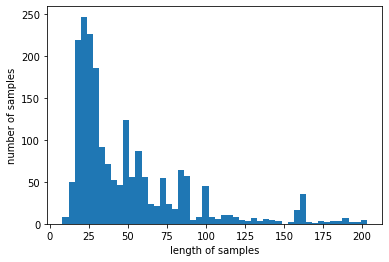

In [461]:
# 패딩 작업(다른 길이의 샘플들의 길이를 동일하게 맞춰줌)

print('리뷰의 최대 길이:',max(len(l) for l in X_train))
print('리뷰의 평균 길이:',sum(map(len, X_train))/len(X_train))

# 그래프로 데이터 길이 분포 알아보기
import matplotlib.pyplot as plt

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#리뷰의 평균 길이는 49지만, 상당수가 50 이하에 분포되어 있기에 max_len을 40으로 잡는다.

In [462]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold(max_len, nested_list):
  count_ = 0
  for i in nested_list:
    if(len(i) <= max_len):
        count_ = count_ + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count_ / len(nested_list))*100))

In [463]:
max_len = 40
below_threshold(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 55.65


In [464]:
# 모든 샘플의 길이를 30으로 맞춤
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 모델 만들기: 1. LSTM으로 감정 분석
- 감정분석에 주로 사용되는 LSTM과 GRU로 모델을 만들어 성능과 소요 시간을 비교해보려고 합니다.

In [465]:
# LSTM으로 TripAdvisor 제주도 호텔 리뷰 감성 분석하기

# 케라스에서 필요한 모듈 임포트
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [466]:
model, es, mc = 0, 0, 0

In [467]:
# 모델의 설정
# 임베딩 차원: 100, 분석을 위해서 LSTM 사용

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid')) # 활성화함수로 시그모이드 사용

In [468]:
# 조기종료값 설정

# 검증 데이터 손실 증가하면 과적합이라는 징후이므로 5회 증가하면 학습을 조기종료함
# ModelCheckpoint로 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장함

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [469]:
# 데이터 불균형 문제 해결 위한 방안: Weight balancing을 사용해보았다.
# 훈련 데이터에서 데이터가 더 적은 클래스에 더 큰 가중치를 두는 방법이다.

# 부정에 해당하는 데이터가 긍정에 비하여 턱없이 작아, 대신 부정 데이터의 가중치를 키워보았다.
from tensorflow import keras

class_weight = {'0': 0.7,
                '1': 0.3}

In [470]:
# 모델 컴파일과 실행

# GRU와의 비교를 위해 학습 시간도 측정해보았습니다

import time
start = time.time()  # 시작 시간 저장

# 에포크는 20번 수행
# 훈련 데이터 중 10%를 검증 데이터로 사용하면서 정확도를 확인함

# optimizer로 adam, 긍부정 이분법적으로 분류하므로 crossentropy, 평가 기준을 accuracy로 설정함
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) 
#history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=10, validation_split=0.1)
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=40, validation_split=0.1, class_weight=class_weight)

print("\n time :", time.time() - start) 

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.1693 - acc: 0.9114
Epoch 00001: val_acc improved from -inf to 0.93500, saving model to best_model.h5
1800/1800 [==============================] - 34s 19ms/sample - loss: 0.1700 - acc: 0.9106 - val_loss: 0.1326 - val_acc: 0.9350
Epoch 2/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.1417 - acc: 0.9182
Epoch 00002: val_acc did not improve from 0.93500
1800/1800 [==============================] - 17s 9ms/sample - loss: 0.1425 - acc: 0.9178 - val_loss: 0.1276 - val_acc: 0.9350
Epoch 3/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9335
Epoch 00003: val_acc did not improve from 0.93500
1800/1800 [==============================] - 17s 9ms/sample - loss: 0.1104 - acc: 0.9339 - val_loss: 0.1684 - val_acc: 0.9350
Epoch 4/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.0776 - acc: 0.9625
Epoch 00004: val_acc

In [471]:
# 결과 출력

# 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 best_model.h5를 로드함
loaded_model = load_model('C:\\Users\\user\\Downloads\\best_model.h5')
#loaded_model = load_model('model')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

997/997 [==============================] - 6s 6ms/sample - loss: 0.3443 - acc: 0.9057

 테스트 정확도: 0.9057


# 모델 만들기: 2. GRU로 감정 분석
- GRU는 LSTM의 장기 의존성 문제에 대한 해결책을 유지하면서, 은닉 상태를 업데이트하는 계산을 줄인 모델이다. 성능은 비슷하지만 훨씬 간단한 모델로서 활용도가 높다. 

In [472]:
# LSTM 값이 GRU에 영향을 미치지 않도록 주요 변수를 초기화 함
model, es, mc = 0, 0, 0

In [473]:
# 모델의 설정
# 분석을 위해서 GRU 사용. LSTM의 결과값과 비교해 보기 위하여 나머지 값들은 모두 동일하게 진행함.

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid')) # 활성화함수로 시그모이드 사용

In [474]:
# 조기종료값 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [475]:
# LSTM와의 비교를 위해 학습 시간도 측정해보았습니다

import time
start = time.time()  # 시작 시간 저장

# 모델 컴파일과 실행
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) 
#history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=10, validation_split=0.1)
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=40, validation_split=0.1, class_weight=class_weight)


print("\n time :", time.time() - start) 

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.1704 - acc: 0.9057
Epoch 00001: val_acc improved from -inf to 0.93500, saving model to best_model2.h5
1800/1800 [==============================] - 35s 20ms/sample - loss: 0.1705 - acc: 0.9056 - val_loss: 0.1264 - val_acc: 0.9350
Epoch 2/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.1356 - acc: 0.9182
Epoch 00002: val_acc did not improve from 0.93500
1800/1800 [==============================] - 16s 9ms/sample - loss: 0.1365 - acc: 0.9178 - val_loss: 0.1245 - val_acc: 0.9350
Epoch 3/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9318
Epoch 00003: val_acc did not improve from 0.93500
1800/1800 [==============================] - 15s 9ms/sample - loss: 0.1091 - acc: 0.9311 - val_loss: 0.1436 - val_acc: 0.9250
Epoch 4/20
1760/1800 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9517
Epoch 00004: val_ac

In [476]:
# 결과 출력
loaded_model = load_model('C:\\Users\\user\\Downloads\\best_model2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

997/997 [==============================] - 5s 5ms/sample - loss: 0.3205 - acc: 0.9057

 테스트 정확도: 0.9057


### 모델 비교 결과: 
LSTM과 GRU가 비슷한 모델이고, 빅데이터를 다루지는 않다 보니 성능이 같게 나왔습니다. 소요 시간은 더 간단한 모델인 GRU가 LSTM보다 4초 빠르게 학습되었습니다. 하지만 큰 차이는 없었는데, 아마도 케라스에서 모듈 형식으로 사용하기 때문에 그런 것이 아닌가라고 추측을 해보았습니다.


# 리뷰 예측해보기

In [576]:
# 리뷰 예측하는 함수 생성

# 현재 학습한 모델에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()
# 훈련 시와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행한 후에 사용해야됨

def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.7):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [577]:
sentiment_predict('정말 최고에요!!! 음식도 맛있고, 수영장도 좋아서 여름에 놀기 짱이에요. 또 오고 싶어요.')

84.81% 확률로 긍정 리뷰입니다.



In [578]:
sentiment_predict('일년에 한 번씩 오는 것 같아요. 가족이 와서 힐링하기 딱인 호텔이라고 생각합니다.')

82.58% 확률로 긍정 리뷰입니다.



In [591]:
sentiment_predict('관리가 하나도 안 됐더라고요. 무척 실망했습니다.')

37.48% 확률로 부정 리뷰입니다.



# 결론과 앞으로 나아갈 방향
- Tripadvisor의 제주도 호텔 리뷰 데이터를 크롤링하고 텍스트 마이닝을 수행했습니다. Tripadvisor의 구조에 맞게 스크래핑 코드를 변형해서 진행해보았고, 리뷰를 긍/부정으로 나누어 감정 분류를 진행해보았습니다. 여러 방안으로 고민해보면서 성능을 높여보고, 또 앞으로 연구해볼 만한 것들에 대하여 정리를 해보았습니다.

> **성능 향상을 위한 해결책:** 처음에는 성능이 70%대로 매우 좋지 않아서 무엇이 문제인가 고민을 해본 결과, 긍정과 부정 데이터셋을 나누는 것에 문제가 있었습니다. 평점이 50점 만점일 때, 데이터에서 40, 50점이 대부분이어서, 처음에는 50점은 긍정, 40점 이하는 모두 부정으로 데이터셋을 나누어 사용했습니다. 그러다보니 정확도가 매우 낮게 나왔고, 부정적인 리뷰를 잘 감지하지 못하는 모습을 보였습니다. 
그래서 해결책으로 **데이터셋을 나눌 때, 50점은 긍정, 40점은 버리고, 30점 이하는 부정**으로 하였습니다. 또한, **Weight balancing 기법을 사용하여 부정 데이터셋의 가중치**를 높여 학습했습니다. 이렇게 한 결과, **정확도가 90%**까지 오를 수 있었습니다.

- 호텔 리뷰 데이터에 대해서 분석을 해본 결과, 대부분이 긍정적인 평가를 남겨, 영화 리뷰, 상품 리뷰 등에 비해 더 biased한 성격을 보였습니다. 이와 같이 데이터의 불균형이 있을 때 Weight balancing, 혹은 Over and under sampling 등의 방법을 이용하여 데이터 불균형 문제를 해결할 수 있습니다. 이번에는 weight balancing 기법을 사용해 보았는데, 다음에는 imblearn 패키지의 SMOTE(Synthetic Minority Oversampling Technique) 샘플링을 사용해보고자 합니다. SMOTE는 샘플들 사이의 특성들을 반영한 데이터가 생성되기 때문에 오버 피팅에 강한 데이터가 생성된다고 합니다. (출처: https://3months.tistory.com/414, https://dining-developer.tistory.com/27)


- TripAdvisor에서 4000개 미만의 데이터를 스크래핑하는 데 시간이 40분 정도 걸리는 것을 파악되었습니다. 스크래핑 시간을 줄일 수 있는 방법에 대해 더 탐구하고자 합니다. GPU를 사용하는 것 외에도 더 효율적인 코딩 등에 대하여 알아보고자 합니다.